In [19]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from scipy.stats import entropy, binom
from scipy.special import comb
import os
import re
from functools import partial
entropy=partial(entropy, base=2)
np.random.seed = 42

Latex macros
$\renewcommand{\vec}[1]{\mathbf{#1}}$
$\renewcommand{\ex}[1]{\mathbb{E}\left[{#1}\right]}$
$\renewcommand{\dkl}[2]{D_\text{KL}\left(\mathbf{#1\|#2}\right)}$
$\renewcommand{\hyp}{\mathcal{H}}$

# Data Compression

## The Source Coding Theorem
How to measure the information content of the outcome of a random experiment?
Why do improbable outcomes convey more information than probable outcomes?

Topics discussed:
- Shannon information and Entropy
- Motivation for the definitions being useful
- Other measures of information: $H_0(X)$, $H_\delta(X)$
- Lossy and loseless compressions
- $S_\delta$ and the typical set $T_{N\beta}$
- Shannon's source coding theorem and the 'Asymptotic equipartition' principle

I thought that we can start with a nice experiment, exploring compression of my Whatsapp message history.

In [146]:
folder = Path("c://Users/ofer/projects/dl-notes/intro_info_theory/res/")
with open(folder/'wiki_snippet.txt', 'r') as f:
    texts = f.readlines()

In [157]:
# lotsa function defintions. names could have been better.

def build_sym_table(s):
    # more like symbol to probability table given string s
    t = "".join(s)
    sym_table = defaultdict(int)
    for s in t:
        sym_table[s] += 1
    for s in sym_table:
        sym_table[s] /= len(t)
    return sym_table

def st_N(st, N):
    # N-sequences of symbols table
    from itertools import product
    prod_st = {}
    for p in product(st.keys(), repeat=N):
        prod_st["".join(p)] = np.prod([st[k] for k in p])
    return prod_st

def delta_subset(st, delta=0.01):
    sym = sorted(st.keys(), key=lambda x:st[x], reverse=True)
    probs = [st[s] for s in sym]
    i = np.searchsorted(np.cumsum(probs), 1-delta)
    return {s:st[s] for s in sym[:i+1]}

def build_encode_table(symbols):
    n_bits = int(np.ceil(np.log2(len(symbols))))
    et = {}
    for i in range(len(symbols)):
        et[symbols[i]] = f"{i:0{n_bits}b}" # convert to binary
    return et

def encode_str(et, s):
    import re
    encoded = []
    # sweet way to split string to chunks
    for c in re.finditer(f'.{{{len(list(et.keys())[0])}}}', s, flags=re.S):
        try:
            encoded.append(et[c.group()])
        except KeyError:
            pass
    return "".join(encoded)

def decode_str(dt, s):

    decoded = []
    for c in re.finditer(f'.{{{len(list(dt.keys())[0])}}}', s, flags=re.S):
        try:
            decoded.append(dt[c.group()])
        except KeyError:
            pass
    return "".join(decoded)
    
def entropy(st):
    prob = np.array(list(st.values()))
    return np.sum(prob * np.log2(1/prob))
    
def print_errors(s, delta, N=1):
    # visualize which part of the text gets corrupted in 
    # the encode/decode process.
    RESET = "\x1b[0m"
    RED = "\x1b[1;31;43m"
    st = build_sym_table(s)
    st_seq = st_N(st, N)
    ds = delta_subset(st_seq, delta)
    it = re.finditer(f'.{{{N}}}', s, flags=re.S)
    print("".join((c.group() if c.group() in ds else RED+c.group()+RESET for c in it )))

In [150]:
st = build_sym_table(texts)
st_2 = st_N(st, 3)
ds = delta_subset(st_2, 0.001)
print(len(st), len(ds))

et = build_encode_table(list(st.keys()))
dt = {v:k for k,v in et.items()}
et_delta = build_encode_table(list(ds.keys()))
dt_delta = {v:k for k,v in et_delta.items()}

encoded_naive = encode_str(et, "".join(texts[:1000]))
decoded_naive = decode_str(dt, encoded_naive)
encoded_delta = encode_str(et_delta, "".join(texts[:1000]))
decoded_delta = decode_str(dt_delta, encoded_delta)


67 156527


In [151]:
print(len(encoded_naive), len(encoded_delta))

25340 21402


In [152]:
print(decoded_delta)

Phages were discovered to be antibacterial agents and were used in the former Soviet Republic of Georgia (pioneered there by Giorgi Eliava with help from the co-discoverer of bacteriophages, Fix d'Herelle) during the 1920s and 1s for treating bacterial infections. They had widespread use, including treatment of soldiers in the Red Army. However, they were abandoned for general use in the West for several reasons:

Antibiotics were discovered and marketed widely. They were easier to make, store, and to prescribe.
Medical trials of phages were carried out, but a basic lack of understanding raised questions about the validity of these trials.[
Publication of research in the Soviet Union was mainly in the Russian or Georgian languages and for many years, was not followed internationally.
The use of phages has continued since the end of the Cold War in Russia,] Georgia and elsewhere in Central and Eastern Europe. The first regulated, randomized, double-blind clinical trial was reported in t

In [153]:
entropy(st)*1000

4510.9387251298895

We can see that if we tolerate an error rate of $\delta=0.1$ we reduce the file to the size mandated by entropy. Of course, nobody wants every 10'th letter to be missing. Here's an illustration:

In [158]:
print_errors("".join(texts[:10000]), 0.01, N=3)

Phages were discovered to be antibacterial agents and were used in the former Soviet Republic of Georgia (pioneered there by Giorgi Eliava with help from the co-discoverer of bacteriophages, FÃ©lix d'Herelle) during the 1920s and 1930s for treating bacterial infections. They had widespread use, including treatment of soldiers in the Red Army. However, they were abandoned for general use in the West for several reasons:

Antibiotics were discovered and marketed widely. They were easier to make, store, and to prescribe.
Medical trials of phages were carried out, but a basic lack of understanding raised questions about the validity of these trials.[18]
Publication of research in the Soviet Union was mainly in the Russian or Georgian languages and for many years, was not followed internationally.
The use of phages has continued since the end of the Cold War in Russia,[19] Georgia and elsewhere in Central and Eastern Europe. The first regulated, randomized, double-blind clinical trial was r

That was fun. Some remarks:
- Illustration of the difference between declaritive and imperative knowledge, or, just because you can do something mathematically (encode sequence of symbols in binary) doesn't mean it's practical computationally.
- Emojis are rare in Avnofifer, but some letters are rarer.
- A $\delta=0.01$ error rate is actually pretty high.

### How to measure the information content of a random variable?
We already defined some notions, _Shannon information content_ of $x=a_i$, $$h(x=a_i)\equiv\log_2\frac1{p_i}$$
the _entropy_ $$H(X)=\sum_xp_i\log_2\frac1{p_i}$$ as the average information content of an ensemble.

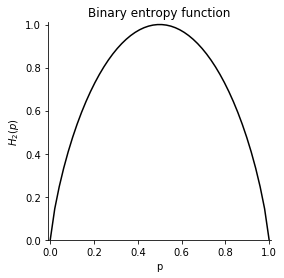

In [34]:
p = np.linspace(0.0001, 0.9999)
H = -p*np.log2(p) - (1-p)*np.log2(1-p)
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(p, H, c='black')
ax.set(title='Binary entropy function', xlabel='p', ylabel='$H_2(p)$')
ax.set(xlim=[-0.01,1.01], ylim=[0,1.01])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Why this formulation of information content, why $\log\frac1p$? It turns out later that those numbers are related to the number of bits needed to describe the outcome of an experiment. For now though, we will see some motivating examples.

Intuitivly we would want independent random variables to convey additive information, ie if $X$ and $Y$ are independent then $H(X,Y)=H(X)+H(Y)$. And indeed,
$$\begin{align}
H(X,Y)&=\sum_x\sum_yP(x,y)\log\frac1{P(x,y)} \\&= \sum_x\sum_yP(x)P(y)\log\frac1{P(x)P(y)} \\
&=\sum_x\sum_yP(x)P(y)\left(\log\frac1{P(x)}+\log\frac1{P(y)}\right) \\
&=\sum_x\sum_yP(x)P(y)\log\frac1{P(x)}+\sum_x\sum_yP(X)P(Y)\log\frac1{P(y)} \\
&=\sum_xP(x)\log\frac1{P(x)}\sum_yP(Y)+\sum_yP(y)\log\frac1{P(y)}\sum_xP(x) \\
&=\sum_xP(x)\log\frac1{P(x)}\cdot1+\sum_yP(y)\log\frac1{P(y)}\cdot1 \\
&=H(X)+H(Y)
\end{align}$$
Nothing like 7 lines to prove something trivial from definitions.

In the chapter's opening, the author presents the weighing problem as a motivator for questions about the nature of information. By coincidence I happened to solve it about a week before (took me ~1.5 days), and I remember coming to the conclusion that the weighings/experiment should have rule out hypotheses equally. At the time I thought of it more like a game where the adversary will choose the outcome which makes it harder for you. Here we think about the hypotheses as probabilities, and so an experiment with equal "division" of results is equiprobable, and we saw in the last part that when the distribution is closer to uniform we maximize the entropy, the average content.

The next example is the guessing game, or a lamer version called **sixty-three**. It demonstrates the connection between the Shannon information content and the size of a file the encodes the outcomes of a random experiment. In the game, you need to guess a number between 0 and 63. 6 bits suffice to represent a number in that range, so six questions (you can formulate the question in "human-speak", $x\mod2^i\geq 2^{i-1}$). If we assume the values of $x$ are equally likely, then the answers to the questions are independent and each answer has $\log(1/0.5)=1\text{ bit}$. From independence we get the total Shannon information gained is always six bits. Hmmm. Also, our questioning defines a way of encoding the random variable $x$ as a binary file, write down the answers. Question, what if the number of questions depends on the number?

Another example is the game of **boring battleships**. A $8\times8$ grid, one square is a submarine. We need to guess where it is. The question is: "how many bits can one bit convey?" The left "bits" is the unit of information and the right is a binary variable. If we get the first guess right, we get $h(x=\text{hit})=\log64=6\text{ bits}$, and interestingly enough, 6 bits encode the location on the grid. Somehow one bit conveyed 6 bits! If on the other hand we miss we get $h(x=\text{miss})=\log\frac{64}{63}=0.0227\text{ bits}$. Let's imagine we miss the first 32 guesses, then
$$\begin{align}\log\frac{64}{63}+\dots+\log\frac{33}{32}\\
=0.0227+\dots+0.0430&=1.0\text{ bits}
\end{align}$$
We ruled out 32 hypotheses, so just like the previous game we got 1 bit. Anyway, no matter at which guess we win the information we gain always sums up to 6 bits.

Lastly, we have **Wenglish**, a fake language with a 32768 long dictionary, the words are all 5 characters long and created by sampling 5 times independently from the **a...z** distribution introduced earlier. Let's imagine we are reading a Wenglish document consisting of words drawn at random. What is the information content of a word? since it's uniform we get $\log32768=15\text{ bits}$. So on average, 3 bits per character. 

What if we get the word a character at a time? It's a bit like 20 questions, we have 5 questions (what is the first/second... letter?) and we want to guess the word. Now, the letters are not uniformly distributed but if the word is $c_1c_2c_3c_4c_5$ then $c_i\sim \mathbf{a\dots z}$ (techincally since the words are already sampled and constant, the actual distribution is a bit different and should be calculated straight from the sampled dictionary). Let's say $c_1=\mathbf{z}$, what is the information content gained? $\log(1/0.001)\simeq10\text{ bits}$! Contrast with $c_1=\mathbf{a}$ where the information content is $\log(1/0.0625)\simeq4\text{ bits}$. How can we make sense of that? since **z** is more rare, there are less words beginning with it, hence our "search" has narrowed down significantly.

A question puzzles me; what if we get two **z**, isn't the information content 20 bits, more then 15 bits? isn't that some kind of contradiction? I'm not sure. It might be related to conditional information, or to the difference in the distributions caused by the sampling. In the text the author takes the 15 bit as a constraint and reasons that the rest of the letters must therefore have less information content.



### Data compression
We now discuss the information content of a source by considering how many bits are needed to describe the outcome of an experiment. If we can show that we can compress data from a particular source into a file of $L$ bits per source symbol and recover the data reliably, then we will say that the average information content of that source (entropy) is at most $L$ bits per symbol.

#### Simple data compression methods that define measures of information content
- count the number of possible outcomes $\left|\mathcal{A}_X\right|$ and encode in bits.  
**The raw bit content** of $X$ is $$H_0(X)=\log_2\left|\mathcal{A}_X\right|$$
- keep only a minimal subset $S_\delta\subseteq\mathcal{A}_X$ s.t $P(S_\delta)\geq 1-\delta$.  
**The essential bit content** of $X$ is
$$H_\delta(X)=\log_2\left|S_\delta\right|$$

The first method is not an actual compression but a naming scheme. It is also loseless. You cannot have a loseless compression which shortens all outcomes (Exercise 4.5).

The second method is lossy, we won't be able to recover all of the data.

What if we consider extended sets? the set of $N$ repetitions of the original ensemble symbols?

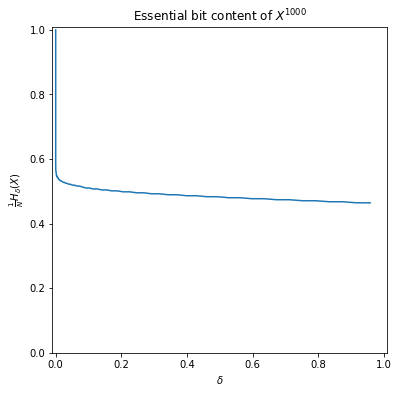

In [101]:
# N flips of a bent coin
# delta = np.linspace(0., 1.)
p=0.90; N=1000
delta = [binom.pmf(k, N, p) for k in range(N+1)]
rang = sorted(list(range(N+1)),key=lambda x:delta[x], reverse=True)
H_delta = [comb(N, k) for k in rang]
# H_delta.sort(key=lambda x:delta[x],reverse=True)
delta.sort(reverse=True)
delta = 1-np.cumsum(delta)
H_delta = np.log2(np.cumsum(H_delta))/N
# delta = np.cumsum(sorted(([binom.pmf(k, N, p) for k in range(N+1)]), reverse=True))[::-1]
# H_delta = np.log2(np.arange(N+1))

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(delta, H_delta)
ax.set(title=f'Essential bit content of $X^{{{N}}}$', xlabel='$\delta$', ylabel='$\\frac{1}{N}H_\delta(X)$')
ax.set(xlim=[-0.01,1.01], ylim=[0,1.01]);
# print(delta)

The graph is lacking the steps, removing symbols from the same category. Could be done but I prefer to move on.

From the graph we learn that up to a certain value we can compress with almost neligible error $\delta$, but we also can't improve beyond it without paying a heavy toll of error rate.

**Theorem 4.1 - Shannon's source coding theorem**. Let $X$ be an ensemble with entropy $H(X)=H$ bits. Given $\epsilon>0$ and $0<\delta<1$, there exists a positive integer $N_0$ such that for $N>N_0$
$$\left|\frac1NH_\delta(X^N)-H\right|<\epsilon$$

Reading the proof now, will note down the definitions.
- typical set
$$T_{N\beta}=\left\{\vec{x}\in\mathcal{A}_X^N\colon\left|\frac1N\log_2\frac1{P(\vec{x})}-H\right|<\beta\right\}$$
so all elements whose information content is $\beta$ bits close to the entropy.
- **'asymptotic equipartition' principle** $N$ iid RV $X^N$ with $N$ big enough, $\vec x$ is almost certain to belong to a subset with $2^{NH(X)}$ mebers each with probability 'close to' $2^{-NH(X)}$
- **CI 1** $t$ non-negative real RV, $\alpha>0$, then
$$P(t\geq\alpha)\leq\frac{\bar{t}}\alpha$$
- **CI 2** $x$ RV, $\alpha>0$, then
$$P((x-\bar x)^2\geq\alpha)\leq\sigma_x^2/\alpha$$
- **Weak law of large numbers** $x$ average of $N$ independent RV having common mean $\bar h$ and variance $\sigma_h^2$, then
$$P((x-\bar h)^2\geq\alpha)\leq\sigma_h^2/\alpha N$$

**Proof:**  
The idea of the proof is to use the typical set as a bound on $S_\delta$. First we prove the asymptotic equipartition principle. We apply the law of large numbers to $f(\vec x)=\frac1N\log_2\frac1{P(\vec x)}$. $f(\vec x)=\frac1N\sum\log\frac1{p(x_i)}$, mean of independent iid RV with means $H=H(X)$ and variance $\sigma^2$ (value doesn't matter). By the definition of $T_{N\beta}$,
$$P(T_{N\beta})=P(\left|\frac1N\log_2\frac1{P(\vec{x})}-H\right|^2<\beta^2)$$
(we added $^2$ but it doesn't change anything)
$$\begin{align}
P(\left|\frac1N\log_2\frac1{P(\vec{x})}-H\right|^2<\beta^2)&=1-P(\left|\frac1N\log_2\frac1{P(\vec{x})}-H\right|^2\geq\beta^2)\\
&\geq1-\frac{\sigma^2}{\beta^2N}
\end{align}$$
as $N\to\infty$, $P(T_{N\beta})\to1$ regardless of $\beta$. Also, if $\vec x\in T_{N\beta}$ then
$$
\left|\frac1N\log_2\frac1{P(\vec{x})}-H\right|<\beta \\
-\beta<\frac1N\log_2\frac1{P(\vec{x})}-H<\beta \\
N(H-\beta)<\log_2\frac1{P(\vec x)}<N(H+\beta) \\
-N(H+\beta)<\log_2P(\vec x)<-N(H-\beta) \\
2^{-N(H+\beta)}<P(\vec x)<2^{-N(H-\beta)}
$$

Now, let there be a $\delta,\epsilon$. for the bound from above $\frac1NH_\delta(X^N)<H+\epsilon$.

How big can the typical set be? we saw that $P(\vec x)>2^{-N(H+\beta)}$ and $P(T_{N\beta})$ cannot be bigger than 1 so
$$\left|T_{N\beta}\right|2^{-N(H+\beta)}<1\\
\left|T_{N\beta}\right|<2^{N(H+\beta)}$$
So let's set $\beta=\epsilon$ and have an $N_0>\frac{\sigma^2}{\epsilon^2\delta}$ and big enough for the asymptotic equipartition. So
$P(T_{N\beta})>1-\delta$ and since $S_\delta$ is the minimal set satisfying $P>1-\delta$ we have
    $$\frac1NH_\delta(X^N)=\frac1N\log_2\left|S_\delta\right|\leq\frac1N\log_2\left|T_{N\epsilon}\right|<\frac1N\log_22^{N(H+\epsilon)}=H+\epsilon$$
    
Now for $\frac1NH_\delta(X^N)>H-\varepsilon$. If we show that there's an $N_0$ s.t for every $N>N_0$ and $S'$ subset having $\left|S'\right|\leq2^{N(H-\varepsilon)}$ it holds that $P(S')<1-\delta$, meaning $\left|S_\delta\right|>2^{N(H-\varepsilon)}$.

We will use the typical set again.
$$P(S')=P(S'\cap T_{N\beta})+P(S'\cap\overline{T_{N\beta}})$$
Now, we can bound both operands, $P(S'\cap T_{N\beta})\leq\left|S'\right|2^{-N(H-\beta)}$ and $P(S'\cap\overline{T_{N\beta}})\leq \frac{\sigma^2}{\beta^2N}$
so,
$$P(S')\leq2^{N(H-\varepsilon)}2^{-N(H-\beta)}+\frac{\sigma^2}{\beta^2N}=2^{-N(\varepsilon-\beta)}+\frac{\sigma^2}{\beta^2N}$$
This holds for every typical set, but if we set $\beta=\varepsilon/2$ and choose $N_0$ big enough then for every $N>N_0$ the expression on the right will be smaller than $1-\delta$ so $P(S')<1-\delta$ regardless of choice.

### Exercises

**Exercise 4.12** How many weights do you need to weight bags of flour with integer weights $1\leq w\leq40$

Can I do it with 40? ofcourse. How about 20? yeah, easy enough. It's a linear combination above $\mathbb{Z_{mod2}}$, a fancy way of saying, can I achieve every number between 1-40 with each weight either contributing +,- or 0.

What's the lower limit on the number of weights I'll need? if I have 3 weights, we get $3^3=27$ linear combinations, not enough to represent 40 numbers. $3^4=81$, seems enough. So at least 4 weights. Let's try solving constructivly. $w_1=1$, $w_2=2$? but then $w_2-w_1=1$ so I waste a combination. Let's choose $w_2=3$. Now I can cover 1-4. At this point I visualized the the next weight I choose has a segment around it with radius 4, covering all the numbers I could reach. So I chose $w_3=9$ to avoid overlap. Now we can cover 1-13 and with the same logic $w_4=27$ and we're done.

_Comment:_ When I solved it in my head I made a mistake so it seemed at first I couldn't cover all 40 numbers. Also, I noticed that if you choose the next weight such that it's bigger then the sum of the previous, you lose all the combinations with it contributing negatively (if you don't use a heavier weight that is). How many combinations are then negative? 40, plus 1 where all the weights are missing, so we got exactly $81-(40+1)=40$ useful combinations for the 40 numbers. Nifty.

**Exercise 4.13**
a) Is it possible to solve the 12 balls weighing problem using a sequence of three _fixed_ weighings?

My initial intuition was no, since it is then "simpler" and therefore easier to come by. The 3 weighings can be characterized by thinking of the "trip" each ball takes. Each ball can start in either the left side, right side or out of the pans. Next it can change or stay. So we get $3^3=27$ possible courses for a ball. That's when I was puzzled, because it seems more than enough to identify a ball.

If we take the easier problem where we know whether the fake is heavier or lighter, can we solve it? well, if we move the balls between weighings in such a way that each ball takes a unique trip than we just need to keep track in each weighing where the pan was lifted/lowered and we should be able to identify the culprit.

What about the original problem? Let's imagine we have one ball that will stay on the left pan during the weighings and one ball that will stay on the right pan. Before, we could tell which one is fake because we knew the weight. Now, if the pans are so $L<R$ during the three weighings we have two possibilites: either the left is fake and its lighter, or the right is fake and it's heavier.

So where's the catch? the problem is that the left ball's 'trip' is a mirror of the right ball's 'trip', ie, if we take the left ball's trip and switch every left pan postioning with a right pan positioning we'll get the right ball's trip. So without knowing the fake weight we can't differentiate between mirrored trips. Luckily though, we can find a set of 13 trips where neither is a mirror of another (I think there's some group theory justification). Well, 13 should be enough for 12 balls, right?

At this point I started coding, as seen below, giving each ball a number and a trip. I ran some tests, looks good! but then, a realization... Back when I originally solved the riddle, I separated the code to different parts, the balance and the algorithm, to make sure the algorithm can't cheat. But now I did everything quickly and just programmed the balance so it would be heavier or lighter where it had the fake coin. There is one problem though; It ignores if the balance has an even number of coins! Looking at the trips I chose, it was obvious some weighings were imbalanced. I could still flip the trips though, so could I fix the situation through flipping and choosing the right trips(I had 14 candidates so I had some flexibility)? Eventually I did, and it works. With 12 balls you can identify which one's the fake and whether it's heavier or lighter. With 13, you can still tell which one's fake but not neccessarily its weight.

Part b) of the exercise is to prove the general case, that with $W$ weighings you can differentiate between $(3^W-3)/2$ balls. I assume you need to somehow prove that there is a set of different unmirrored trips that even up in each weighing, like I found heuristically.

In [353]:
L = 'L'
R = 'R'
O = 'O'

def f(tup):
    d = {L:R, R:L, O:O}
    return (d[tup[0]], d[tup[1]], d[tup[2]])

weighings = {#1: (O,O,O),
             2: (L,O,O),
             3: (O,L,O),
             4: (L,L,O),
             5: (R,L,O),
             6: f((O,O,L)),
             7: f((L,O,L)),
             8: f((R,O,L)),
             9: f((O,L,L)),
#              10:(L,L,L),
             10:(R,L,L),
             11:(O,R,L),
             12:(L,R,L),
             1:(R,R,L)}

def weigh(weighings, n, sign='<'):
    res = []
    for i in range(3):
        if weighings[n][i] == O:
            res.append('=')
        elif weighings[n][i] == R:
            res.append(R+sign+L)
        elif weighings[n][i] == L:
            res.append(L+sign+R)
    return res

sign = '<' if np.random.randint(0, 2) else '>'
n = np.random.randint(1, 13)
weigh(weighings, n, sign)

['=', 'R<L', 'R<L']

In [354]:
n, sign

(9, '<')

**Exercise 4.20** Sketch $f(x)=x^{x^{x^{x^{x^{.^{.^{.}}}}}}}$. _Hint:_ find the inverse function.

## Symbol Codes

The author states we must do exercise 2.26 before we continue.

**Exercise 2.26** Prove that the relative entropy satisfies $D_\text{KL}(P\|Q)\geq0$ (Gibbs' inequality) with equality if $P=Q$.

Reminder: relative entropy between $P(x)$ and $Q(x)$
$$\dkl{P}{Q}=\sum_xP(x)\log\frac{P(x)}{Q(x)}$$

Regarding the equality, if $P=Q$ then $\log\frac{P(x)}{Q(x)}=0$ for every $x$. Looking back to chapter 2, there was a hint there to use Jensen's inequality, $\ex{f(\vec{x})}\geq f(\ex{\vec{x}})$ where $f$ is convex and $\vec x$ is a random variable.

We'll choose $f=-\log$ and $\vec x=\frac{Q(x)}{P(x)}$. So, we have
$$\begin{align}
\sum_xP(x)\log\frac{P(x)}{Q(x)} &= \sum_xP(x)-\log\frac{Q(x)}{F(x)} \\
&= \ex{-\log\frac{Q(x)}{P(x)}} \qquad\text{ expectation over P distribution} \\
&\geq -\log\ex{\frac{Q(x)}{P(x)}} \\
&=-\log\sum_xP(x)\frac{Q(x)}{P(x)} \\
&=-\log\sum_xQ(x)=-\log1=0
\end{align}$$

We also get the other side, if we have equality then from Jensen's inequality $\frac{Q(x)}{P(x)}$ is a constant, so $Q(x)=P(x)$.
Can't say I've gained some insight from proving this but, `"We have proved it, therefore it must be true"` or something like that.

In this chapter we'll talk about lossless symbol codes, which encode one source symbol at a time. Since we want compression, some codewords will be shortened, but invariably others will be lengthened. Also, we care about practicality, so we want the codes to be easy to decode, and optimal in the compression.

Formally, A **(binary) symbol code** $C$ for an ensemble $X$ is a mapping from $\mathcal{A}_X$ to $\{0,1\}^+$. $c(x)$ will be the code word and $l(x)$ the length. The _extended code_ $C^+$ is obtained by concatenation without punctuation.

For example, we can encode $\mathcal{A}_X=\{a,b,c,d\}$ as 

| $a_i$ | $c(a_i)$ | $l_i$ |
| ----- |:--------:|:-----:|
| a | 1000 | 4 |
| b | 0100 | 4 |
| c | 0010 | 4 |
| d | 0001 | 4 |

What will we require from such codes? For it to be useful, we want any encoded string to have a unique decoding, and to be easy to decode.

**Unique decodeablity**
$$\forall\vec{x},\vec{y}\in\mathcal{A}_X^+, \vec{x}\neq\vec{y}\Rightarrow c^+(\vec{X})\neq c^+(\vec{Y})$$

One way to have an easily decodeable code is to use prefix code, where each code is **not** a prefix of another code. That way, we can indentify the end of a codeword as soon as it arrives.

Example: $C=\{0,10,110,111\}$ is a prefix code.

**Exercise 5.8:**  is $C=\{1,101\}$ uniquely decodeable?  
Yes. It is not a prefix code, but, we can identify the end of a codeword one character later. If the next character is a 1, then the last one was the codeword $1$, otherwise we get a zero and we expect $101$.

**The expected length** $L(C,X)$ of a symbol code $C$ for ensemble $X$ is
$$L(C,X)=\sum_{x\in\mathcal{A}_X}P(x)l(x)$$

It turns out there is a "budget" to how we can choose codewords if we want to retain unique decodeability. It is stated by the following:

**Kraft inequality** For any uniquely decodeable code $C(X)$ over the binary alphabet $\{0,1\}$, the codeword lengths must satisfy:
$$\sum_{i=1}^I2^{-l_i}\leq1$$
where $I=\left|\mathcal{A}_X\right|$. A uniquely decodeable code that satisfies this equality is called a _complete code_.  
**Proof:** The full proof is in the book. I'll summarize the ideas. We will show that the quantity $S=\left[\sum_i2^{-l_i}\right]$ holds than for all $N$, $S^N$ is bounded from above by a linear function, and since it is an exponential we conclude the base $S\leq1$.

In order to show that, we observe that $S^N$ is a summation of the budget of encodings of words of length N symbols, and since it is invariable to the actual encoding and only cares for the length, we can write
$$S^N=\sum_{l=Nl_\text{min}}^{Nl_\text{max}}2^{-l}\#\{\text{N-words that have l-length encoding}\}$$

From unique decodeability which means one-to-one, we can deduce that $\#\{\text{N to l}\}\leq2^l$ so
$$S^N\leq\sum_{l=Nl_\text{min}}^{Nl_\text{max}}1\leq Nl_\text{max}$$
and it is indeed bounded.

**Exercise 5.14** Prove that for any set of codeword lengths $\{l_i\}$ satisfying the Kraft inequality, there is a prefix code having those lengths.  
**Proof:** let $l_1,\dots,l_n$ be lengths of codewords satisfying $\sum_il_i\leq1$ and $l_1\leq l_2\leq\dots l_i\leq\dots\leq l_n$. We will define the following codewords: for each $i$, $c_i$ will be the binary representation of the fractional part of $S_i=\sum_{j=1}^{i-1}2^{-l_j}$.
1. It is well defined. Since $S_i$ is a sum of numbers with finite binary representation, $S_i$ has a finite binary representation. for $i < j$, $S_i<S_j$. The binary fractional encoding can result in the same encoding if the difference between two numbers is an integer and since $\sum_il_i\leq1$, $c_i\neq c_j$ ($S_n=\sum_i^{n-1}2^{l_i}<1$ so no worries).
2. $l(c_i)\leq=l_i$: the binary rep of each element in $S_i$ is shorter then $l_i$, therefore the binary rep of $S_i$ is. If it is proper lesser, we can always extend by adding trailing zeros.
3. It is a prefix code: Let's assume that for some $i<j$ we have $c_j=c_i+d$. That means that $c_j-c_i=\underbrace{0\dots0}_{l_i\text{ times}}d$. From that we can deduce that $S_j-S_i<2^{-l_i}$, but we also have $S_j-S_i=\sum_{k=i}^{j-1}2^{-l_k}\geq2^{-l_i}$ and so, contradiction.

So far we haven't been talking about probabilities, but about lengths. The problem now is to find a strategy for assigning codewords lengths in regards to the probability of a symbol, in order to minimize $L(C,X)$. How much can we minimize it? it turns out, unsurprisingly that for a uniquely decodeable code $C$
$$H(X)\leq L(C,X)$$
To see that we define the implicit probabilities $q_i=2^{\frac{-l_i}z}$ where $z=\sum_{i'}2^{-l_{i'}}$ is a normalizing factor. Then
$$\begin{align}
L(C,X) &=\sum_ip_il_i=\sum_ip_i\log1/q_i-\log z & l_i=\log1/q_i-\log z\\
&\geq\sum_ip_i\log1/p_i-\log z & \text{Gibbs' inequality}\\
&\geq H(X) & z\leq1\Rightarrow-\log z\geq0
\end{align}$$
Equality is achieved if $z=1$ and $l_i=\log(1/p_i)$.

We are bounded by the entropy, but how close can we get?

**Theorem - Source coding theorem for symbol codes** For an ensemble $X$ there exists a prefix code $C$ with expected length satisfying
$$H(X)\leq L(C,X)<H(X)+1$$

So, the average symbol length is guaranteed to be no more than one bit above the entropy. The usefulness of this result depends on the entropy. If it is 1 bit then the gurantee is we can do no more than twice as bad, which is not a big comfort. As the entropy scales the 1 bit becomes negligible.

Sometimes we can't use the best codelengths because the probabilities are not a power of two. How bad will it be? if $\{p_i\}$ is the probabilities and $\{q_i\}$ the implicit, then
$$L(C,X)=H(X)+\dkl{p}{q}$$

Now the only a question remaining is, how do we actually find an optimal code for given probabilities $\mathcal{P}$?  

The huffman coding algorithm is a simple algorithm for finding an optimal prefix code. You iterate over two steps:
1. Take the least two probable symbols in the alphabet. Create a tree node and have them as the left and right children. 
2. Combine their symbols to one and sum their probabilities.

Since each step reduces the number of symbols by 1, we expects $\left|\mathcal{A}_X\right|-1$ steps. In the end we have a binary tree, and the codewords will be the paths to the leaves.

Here's an implementation:

In [46]:
# huffman code implementation
        
def huffman(ens):
    codes = {k:"" for k in ens}
    a = [(v,[k]) for k,v in ens.items()]
    a.sort(key=lambda x:x[0])
    for i in range(len(ens)-1):
        l, r = a[0], a[1]
        for s in l[1]:
            codes[s] += "0"
        for s in r[1]:
            codes[s] += "1"
        a[0] = (l[0]+r[0], l[1]+r[1])
        a.pop(1)
        a.sort(key=lambda x:x[0])
    return {k:v[::-1] for k,v in codes.items()}

def L(codes, ens):
    return sum((ens[x]*len(codes[x]) for x in ens))
        

**Exercise 5.16** Prove that there is no better symbol code for a source than the Huffman code.

$[p_1,\dots,p_n]$ arranged in increasing order
from induction, $[p_1+p_2,\dots,p_n]$ will be optimal, so
$\sum_{i=3}^n p_i\log\frac{p_i}{q_i}+(p_1+p_2)\log\frac{p_1+p_2}{q_t}$ is minimal

$L(C,X) = L(C,X-1) + p_1+p_2$ for huffman

Let's have a code of n symbols. Lets make it a code for n-1 symbols by combining the least probable symbols and choosing the shorter code for them. From the assumption $L(C`,X-1)\geq L(C,X-1)$.
$L(C`,X)=L(C`,X-1)+$ meh, this is the wrong approach.
lets look at relative entropy

_Spent a couple of hours yesterday, so far no strategy._

Okay, it's been a week and three thinking sessions spread across three days. Finally I believe I have a solution, and it's quite simple.

First of all, lets observe a couple of facts. Again, $[p_1,p_2,\dots,p_n]$ is sorted in increasing order($n\geq3$). Now, assuming $C$ is an optimal code for $X$, there are two symbols with equal and longest codeword length, $a$ and $b$. How so? An optimal code is always complete, otherwise there's a node with one child, and in that case we could cut the node and shorten the associated codewords with no cost. Also, if we look at the leaf for the longest codeword, it's parent must have another child and it must be a leaf as well, so that's our pair. Now, if $C$ is optimal, then $p(a)$ and $p(b)$ must be equal to $p_1$ and $p_2$, since otherwise we could switch $a$ or $b$ with $s_{p_1}/s_{p_2}$ and reduce the expected length, contradicting optimality (the only case where we can't reduce is when all the words have the same length, $p_1$ and $p_2$ will also have longest codewords).

We're ready to prove by induction:
- Base: $n=2$, there is one optimal code, $\{0,1\}$ and Huffman generates it.
- Let's assume Huffman generates an optimal code for ensembles with $n$ symbols. Let $X$ be an ensemble with $n+1$ symbols, and let $C$ be an optimal code for it. Following the last paragraph, we can assume it has $p_1$ and $p_2$ as neighbouring leaves with longest codeword. If we replace them with a new symbol with the sum of probabilites, we get a new ensemble $X'$ of size $n$, and a new code $C'$, with a word shorter by 1 bit for the new symbol. Also, $$L(C,X)=L(C',X')+p_1+p_2$$From induction, $$L(C',X')\geq L(C_{H(X')}, X')$$Now, what we did was exactly the first step of the Huffman algorithm for ensemble $X$, so $C_{H(X)}$ is $C_{H(X')}$ but instead of one codeword for the new symbol we have two codewords one bit longer for $p_1$ and $p_2$. Therefore, $$L(C_{H(X)},X)=L(C_{H(X')},X')+p_1+p_2\leq L(C',X')+p_1+p_2=L(C,X)$$and we have shown Huffman is optimal.

Definitely a wordy proof, and not phrased in the most elegant way, but it's good enough for me.

In theory, the Huffman code is optimal. But what about in practice? How reslient is Huffman to a change in probabilities? Apparently not well.

In [42]:
for i in range(0,70,5):
    p = i/100.
    ens = {'a':0.7-p, 'b':0.20, 'c':0.10, 'd':p}
#     print(ens)
    print(huffman(ens))

{'a': '1', 'b': '01', 'c': '001', 'd': '000'}
{'a': '1', 'b': '01', 'c': '001', 'd': '000'}
{'a': '1', 'b': '01', 'c': '000', 'd': '001'}
{'a': '1', 'b': '00', 'c': '010', 'd': '011'}
{'a': '0', 'b': '111', 'c': '110', 'd': '10'}
{'a': '0', 'b': '111', 'c': '110', 'd': '10'}
{'a': '0', 'b': '111', 'c': '110', 'd': '10'}
{'a': '11', 'b': '101', 'c': '100', 'd': '0'}
{'a': '10', 'b': '111', 'c': '110', 'd': '0'}
{'a': '10', 'b': '111', 'c': '110', 'd': '0'}
{'a': '011', 'b': '00', 'c': '010', 'd': '1'}
{'a': '011', 'b': '00', 'c': '010', 'd': '1'}
{'a': '000', 'b': '01', 'c': '001', 'd': '1'}
{'a': '000', 'b': '01', 'c': '001', 'd': '1'}


I guess the problem is there's maybe no way to reduce computation by using a previous tree?

In the next chapter we will examine _arithmetic coding_ , an alternative to symbol codes which dispenses with the requirement of an integer number of bits per symbol.

### Exercises
**Exercise 5.19** Not uniquely decodeable. The string $111111$ can be interperted as three $11$ or two $111$.  
**Exercise 5.20** Is uniquely decodeable, is prefix code.  
**Exercise 5.21** Let's cheat!


In [63]:
ens = {'0':0.6, '1':0.4}
# ens_pow = [st_N(ens, n) for n in range(1, 5)]
for n in range(1,5):
    e = st_N(ens, n)
    h = huffman(e)
    print(f"X^{n}: L(C,X)={L(h,e):.4f}, H(X)={entropy(e):.4f}")
    print(f"L-H={L(h,e)-entropy(e):.4f}")

X^1: L(C,X)=1.0000, H(X)=0.9710
L-H=0.0290
X^2: L(C,X)=2.0000, H(X)=1.9419
L-H=0.0581
X^3: L(C,X)=2.9440, H(X)=2.9129
L-H=0.0311
X^4: L(C,X)=3.9248, H(X)=3.8838
L-H=0.0410


**Exercise 5.25** If each probability $p_i=2^{-l_i}$ then there exists a source code whose expected length equals the entropy.  
If you define the lengths $l_i$ then the implicit probabilities $q_i$ hold that $\dkl{p}{q}=0$ and therefore $L(C,X)=H(X)$

**Exercise 5.30** The poisoned glass.
I think there were 129 glasses, so 128 could be represent with binary and the spare had to be drank by it's own. Let's think about it with symbol coding.

In [163]:
n = 9
ens = {str(i):1/n for i in range(1,n+1)}
huffman(ens)
# L(huffman(ens), ens)

{'1': '100',
 '2': '101',
 '3': '010',
 '4': '011',
 '5': '000',
 '6': '001',
 '7': '1110',
 '8': '1111',
 '9': '110'}

We can improve on that using probability! Never ceases to amaze. Any way, as you can see above for the case of $2^3+1$, all but two hypotheses have 3-digit codewords. We can design our tests as follows: for each bit, we pour a mixture of all the drinks with that bit equal 1. If we get a positive we know the first bit is one et cetera. If the poision is in one of the glasses with 3 digit codewords, we'll know after 3 experiments.

**Exercise 5.31** $\vec{C}=c(x_1)c(x_2)\dots$, with $X$ ensemble introduced in the beginning of the chapter and the code $C_3$. We pick a random bit from $\vec{C}$, what is the probability it is 1?

Thats actually a nice and tricky question. Tricky because it is not clear how we work with a distribution on an infinite string. It seems like using the sum rule would make our life easier, but under which events?

First approach: $\sum_{i=1}^4p(1\mid c(a_i))p(c(a_i))$, probability of 1 given we landed on $c(a_i)$. So the conditional part is easy, but what about the prior? Obviously it is related to the probability of the letter and the length of the codeword, but not clear how to justify.

Another approach was motivated by the following thought: let's imagine the code tree as kind of an automata. On each stage we stand on a node, and we wait for the next bit. What is the probability that the next one is 1? it is always $0.5$. So what if we could say, we picked a bit at random, let's think about the automata before the bit was received, what is the probability that the bit we landed on/received is 1?

Anyway, this is kind of mumbo jumbo but then the formula emerged
$$p(1)=\sum_{i=1}^3p(1\mid \text{i-st digit})p(\text{i-st digit})$$
ie the probability of digit being one given we landed on the i-st digit of the codeword, and we see that $p(1\mid \text{i-st digit})$ is always $0.5$, so
$$p(1)=\frac12\sum_{i=1}^3p(\text{i-st digit})=\frac12$$

**Exercise 5.32** Just a guess, but instead of taking the lowest 2, take the lowest q

## Stream Codes

Why the name stream codes? I believe that the encoding and decoding can be done on a stream, ie the file doesn't have to be examined in advance.

Two codes are introduced in this chapter, _Arithmetic coding_ and _Lempel-Ziv coding_. They both solve the 1-bit symbol encoding overhead of the Huffman coding, by seamlessly encoding longer strings.

Implementation of arithmetic codes:

In [132]:
def binfrac(s):
    if s == '':
        return 0
    return int(s, base=2) / (1 << len(s))

def encode_arith(x, sym, pd):
    u = 0.
    v = 1.
    p = v - u
    enc = ''
    for n in range(len(x)-1):
        a_i = x[n]
        Q = sum((pd(a, x[:n]) for a in sym[:sym.index(a_i)]))
        R = Q + pd(a_i, x[:n])
        v = u + p*R
        u = u + p*Q
        p = v - u
#         while binfrac(enc) < u:
#             print(u, v, binfrac(enc), binfrac(enc+'1'), enc)
#             can_add_1 =  binfrac(enc+'1') < v
#             if not can_add_1:
#                 enc += '0'
#             elif u <= binfrac(enc+'01') < v:
#                 break
#             else:
#                 enc += '1'
    while binfrac(enc) < u:
        print(u, v, binfrac(enc), binfrac(enc+'1'), enc)
        can_add_1 =  binfrac(enc+'1') < v
        if not can_add_1:
            enc += '0'
        else:
            enc += '1'
    return enc, u, v

In [134]:
ens = {'a': 0.425, 'b': 0.425, 'e': 0.15}
def p_bent(s, cond):
    # modeled using rule of succession
    # https://en.wikipedia.org/wiki/Rule_of_succession
    if 'e' in cond:
        return 1. if s == 'e' else 0.
    if s == 'e':
        return ens[s]
    if cond == "":
        return ens[s]
    p_a = (cond.count('a') + 1) / (cond.count('a') + cond.count('b') + 2)
    return (p_a if s == 'a' else 1 - p_a) * .85
encode_arith("bbbae", list(ens.keys()), p_bent)


0.59659375 0.6226940625 0 0.5 
0.59659375 0.6226940625 0.5 0.75 1
0.59659375 0.6226940625 0.5 0.625 10
0.59659375 0.6226940625 0.5 0.5625 100
0.59659375 0.6226940625 0.5625 0.59375 1001
0.59659375 0.6226940625 0.59375 0.609375 10011


('100111', 0.59659375, 0.6226940625)

In [127]:
print(binfrac('100111101'), binfrac('10011111'))
print(binfrac('1001111100'), binfrac('1001111101'))

0.619140625 0.62109375
0.62109375 0.6220703125


Okay I'll stop for now. Surprisingly tricky, this took me two hours so far. The encoding is a bit confusing, ie how to decide whether a digit is certain. Also when terminating, my approach failed and cost an extra bit...

**Exercise 6.1** Show the overhead required to terminate a message is never more than 2 bits, relative to the ideal message length given the probabilistic model $\mathcal{H}$, $h(\vec x\mid\mathcal{H})=\log\left[1/P(\vec x\mid\mathcal{H}\right)]$

$P(\vec x\mid\hyp)=\prod_i^NP(x_i\mid x_1\dots x_{i-1},\hyp)$, so
$$h(\vec x\mid\hyp)=\sum\log\left[1/P(x_i\mid x_1\dots x_{i-1},\hyp)\right]$$

My head isn't working today...

In general if $I$ is an interval of width $w$,


So what is arithmetic coding? Let's consider a binary file. If we think of the bits as the fractional part of a binary representation, we can think of the file as an interval contained in the interval $[0, 1)$.

For example, the string $01101$ defines the interval $[0.01101, 0.01110)$ (in binary). The string $01110$ defines the interval $[0.01110, 0.01111)$. Now, let's say we have an ensemble and a distribution, we could divide the interval $[0,1)$ so that each subinterval corresponds to the probability of a symbol. So, for symbol $a_i$, subinterval $I_i$ will hold
$$\left|I_i\right| = p(a_i)$$. Next, for the pair $a_ia_j$, we can divide the interval $I_i$ according to the distribution $p(a\mid a_i)$ so
$$\left|I_{ij}\right| = p(a_j\mid a_i)*\left|I_i\right|=p(a_j\mid a_i)*p(a_i)=p(a_j,a_i)$$
and so forth. The intuition is that bigger intervals will require less binary digits to represent and with our modeling bigger intervals will correspond to more likely sequences. The encoding will be a binary string whose interval lies within the sequences interval.

## Codes for Integers

TBD

## More huffman optimality proof investigation

_Getting it out of the way_

Im investigating the idea of starting from assigning ceiling of information content length to each codeword and reducing from there on some greedy basis. It seems though that huffman sometimes reduces more then one bit.

I think you can actually formulate this as a knapsack problem. If we start from the ceiling values. Each bit we reduce decreases $L(C,X)$ but costs us $2^{l_i}$ from our budget. It's a bit trickier since we get access to later bits only by choosing earlier ones, but since their value/price always diminishes every optimal solution will be consistent in that regard. This doesn't help much since knapsack is NP-hard.

In [155]:
abc = {
    'a':0.0575,
    'b':0.0128,
    'c':0.0263,
    'd':0.0285,
    'e':0.0913,
    'f':0.0173,
    'g':0.0133,
    'h':0.0313,
    'i':0.0599,
    'j':0.0006,
    'k':0.0084,
    'l':0.0335,
    'm':0.0235,
    'n':0.0596,
    'o':0.0689,
    'p':0.0192,
    'q':0.0008,
    'r':0.0508,
    's':0.0567,
    't':0.0706,
    'u':0.0334,
    'v':0.0069,
    'w':0.0119,
    'x':0.0073,
    'y':0.0164,
    'z':0.0007,
    '-':0.1928
}
h_abc = huffman(abc)
temp = {}
# sorted(abc.keys(), key=lambda x:abc[x], reverse=True)
def max_short(l, budget):
    bits = 0
    cost = 2.**-l
    while(cost+budget <= 1. and bits < l):
        bits += 1
        cost += 2.**-(l-bits)
    return bits, cost
def budget(c):
    return sum((2**-len(code) for code in c.values()))
def u(x):
    ic = np.log2(1/abc[x])
    ce = int(np.ceil(ic))
    bits, cost = max_short(ce, budget(temp))
    if cost == 0:
        return 0
    return abc[x]/cost
for k in sorted(abc.keys(), key=u, reverse=True):
    ic = np.log2(1/abc[k])
    ce = int(np.ceil(ic))
    temp[k] = '0'*ce
    
    print(f"{k}  {abc[k]}  {ic:4.1f} {ce:2} {len(h_abc[k]):2}  {abc[k]/2**(-ce):.4f} {u(k):.4f}")



-  0.1928   2.4  3  2  1.5424 0.1028
e  0.0913   3.5  4  4  1.4608 0.0974
t  0.0706   3.8  4  4  1.1296 0.0753
o  0.0689   3.9  4  4  1.1024 0.0735
i  0.0599   4.1  5  4  1.9168 0.0618
n  0.0596   4.1  5  4  1.9072 0.0615
a  0.0575   4.1  5  4  1.8400 0.0594
s  0.0567   4.1  5  4  1.8144 0.0585
r  0.0508   4.3  5  5  1.6256 0.0524
l  0.0335   4.9  5  5  1.0720 0.0346
u  0.0334   4.9  5  5  1.0688 0.0345
h  0.0313   5.0  5  5  1.0016 0.0668
d  0.0285   5.1  6  5  1.8240 0.0588
c  0.0263   5.2  6  5  1.6832 0.0543
m  0.0235   5.4  6  6  1.5040 0.0485
p  0.0192   5.7  6  6  1.2288 0.0396
f  0.0173   5.9  6  6  1.1072 0.0357
y  0.0164   5.9  6  6  1.0496 0.0339
g  0.0133   6.2  7  6  1.7024 0.0270
b  0.0128   6.3  7  6  1.6384 0.0260
w  0.0119   6.4  7  7  1.5232 0.0242
k  0.0084   6.9  7  7  1.0752 0.0171
x  0.0073   7.1  8  7  1.8688 0.0147
v  0.0069   7.2  8  8  1.7664 0.0139
q  0.0008  10.3 11  9  1.6384 0.0016
z  0.0007  10.5 11 10  1.4336 0.0014
j  0.0006  10.7 11 10  1.2288 0.0012
(